In [1]:
import os
import re
import yaml

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from numpy import asarray

In [2]:
# Paths and input

# This is the Leiden clustering, just using for channel intensity values though
df = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

cylinter_config_path = '/Volumes/T7 Shield/cylinter_input/clean_quant/config.yml'
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['channelExclusionsClustering']

abx_channels = [
    i for i in df.columns if i.split('_nucleiRingMask')[0]
    in list(markers['marker_name']) if dna_moniker not in i
    if i not in markers_to_exclude]

out = os.path.join(os.getcwd(), 'output/3d_umap_channels')
if not os.path.exists(out):
    os.makedirs(out)

CD4_488


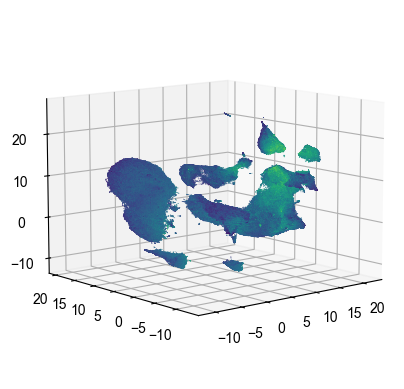

FOXP3_570


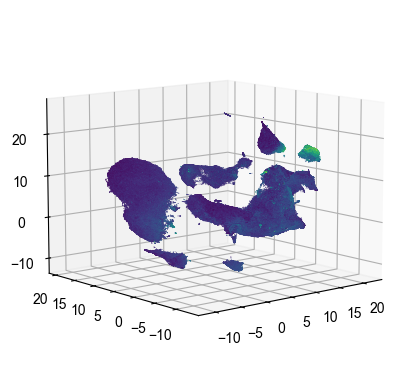

CDX2_647


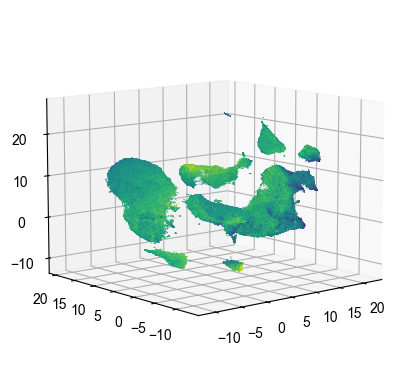

CD8a_660


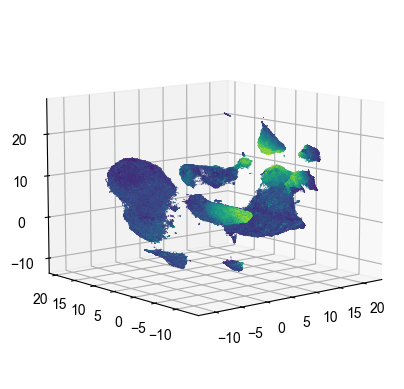

CollagenIV_647


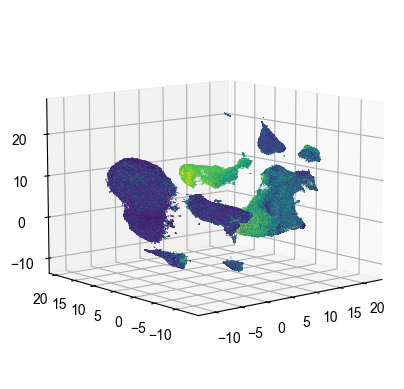

Desmin_555


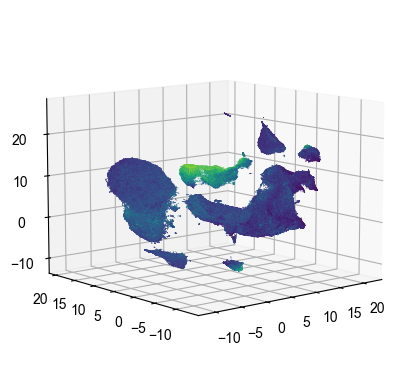

anti_CD45RO


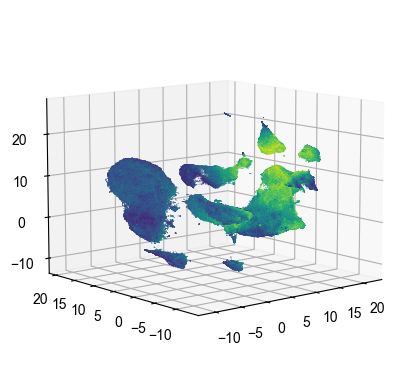

CD45_PE


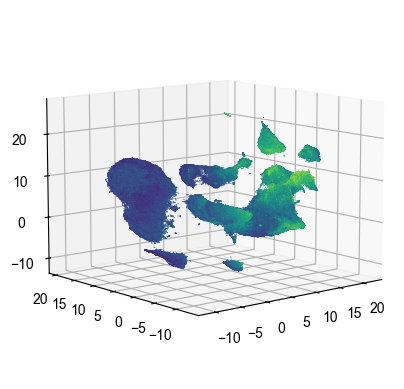

anti_CD3


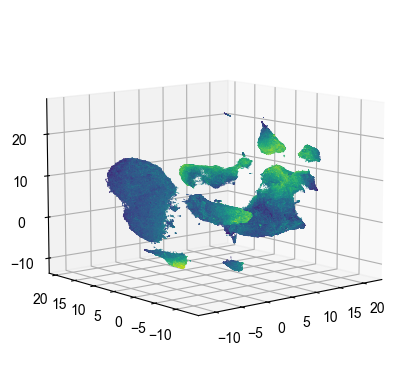

LaminABC_488


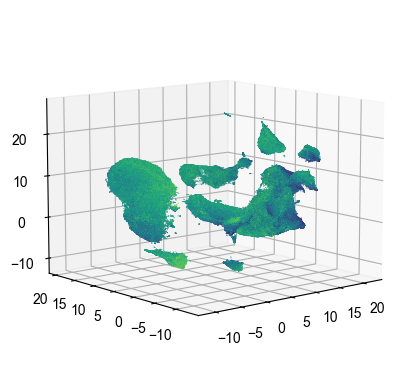

PD1_647


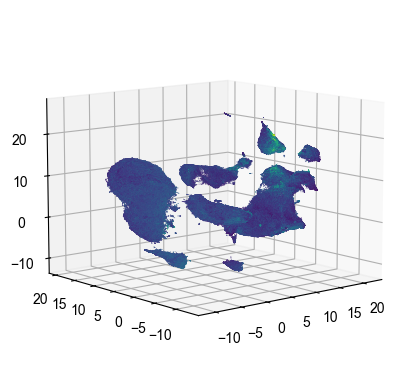

CD20_488


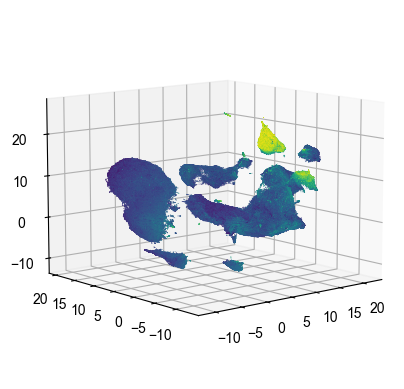

Keratin_570


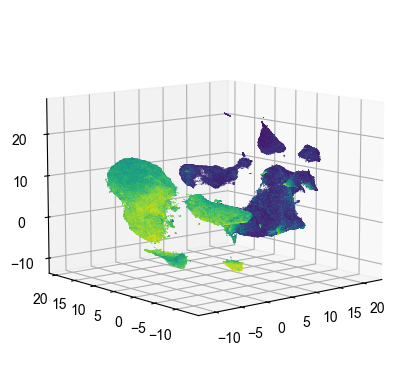

CD31_647


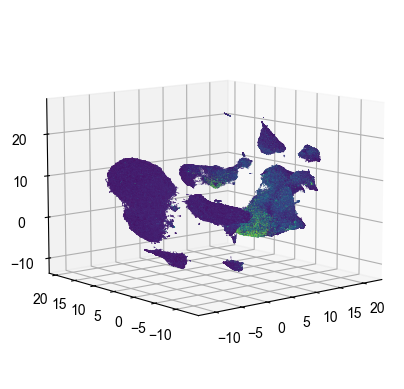

Ecad_488


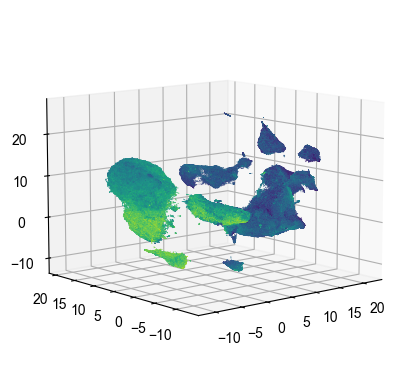

PDL1_647


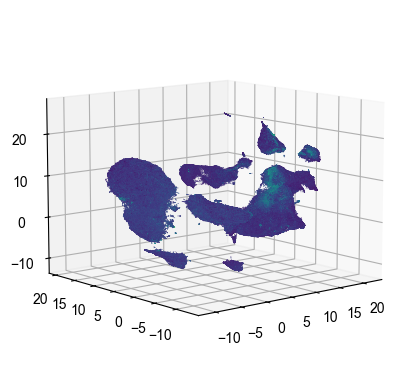

CD68_555


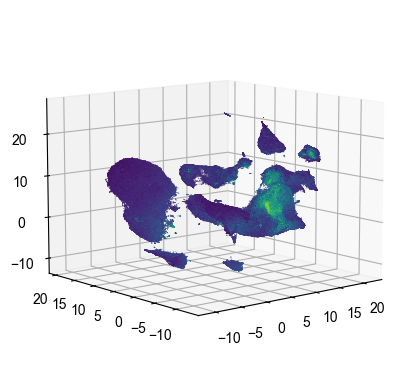

CD163_488


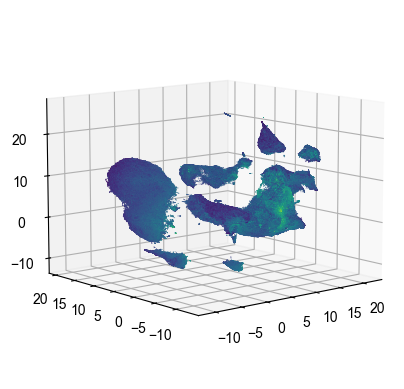

PCNA_488


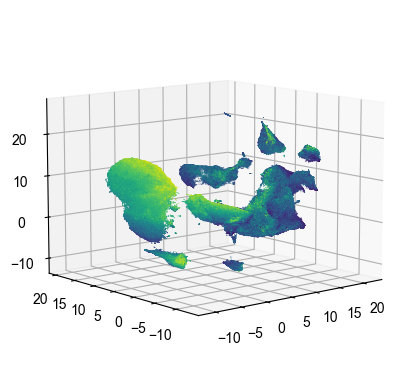

Vimentin_555


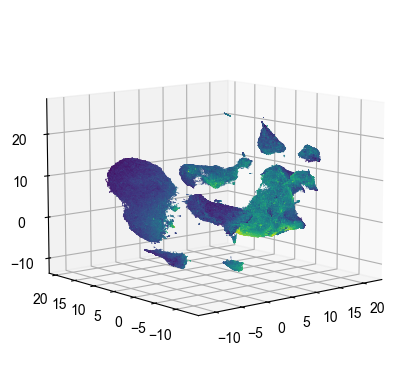

aSMA_660


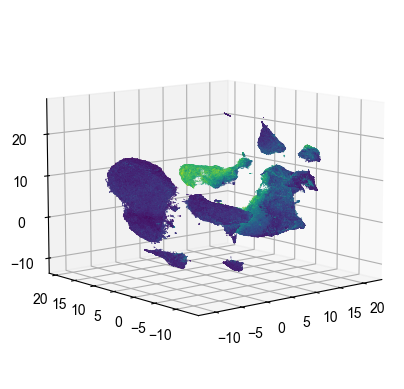

In [3]:
# Generate individual channel PNGs
plt.rcParams['font.family'] = 'Arial'

for ch in abx_channels:
    print(ch.split('_nucleiRingMask')[0])
    fig = plt.figure()
    ax = plt.axes(projection='3d', computed_zorder=False)
    ax.view_init(azim=-130, elev=10)
    ax.scatter(
        df['emb1'], df['emb2'], df['emb3'], c=df[ch],
        linewidth=0.1, s=150000 / len(df))
    ax.axis('auto')
    ax.tick_params(labelsize=10)
    ax.grid(True)
    plt.savefig(
        os.path.join(out, f"{ch.split('_nucleiRingMask')[0]}.png"),
        bbox_inches='tight', dpi=800
    )
    plt.show()
    plt.close('all')

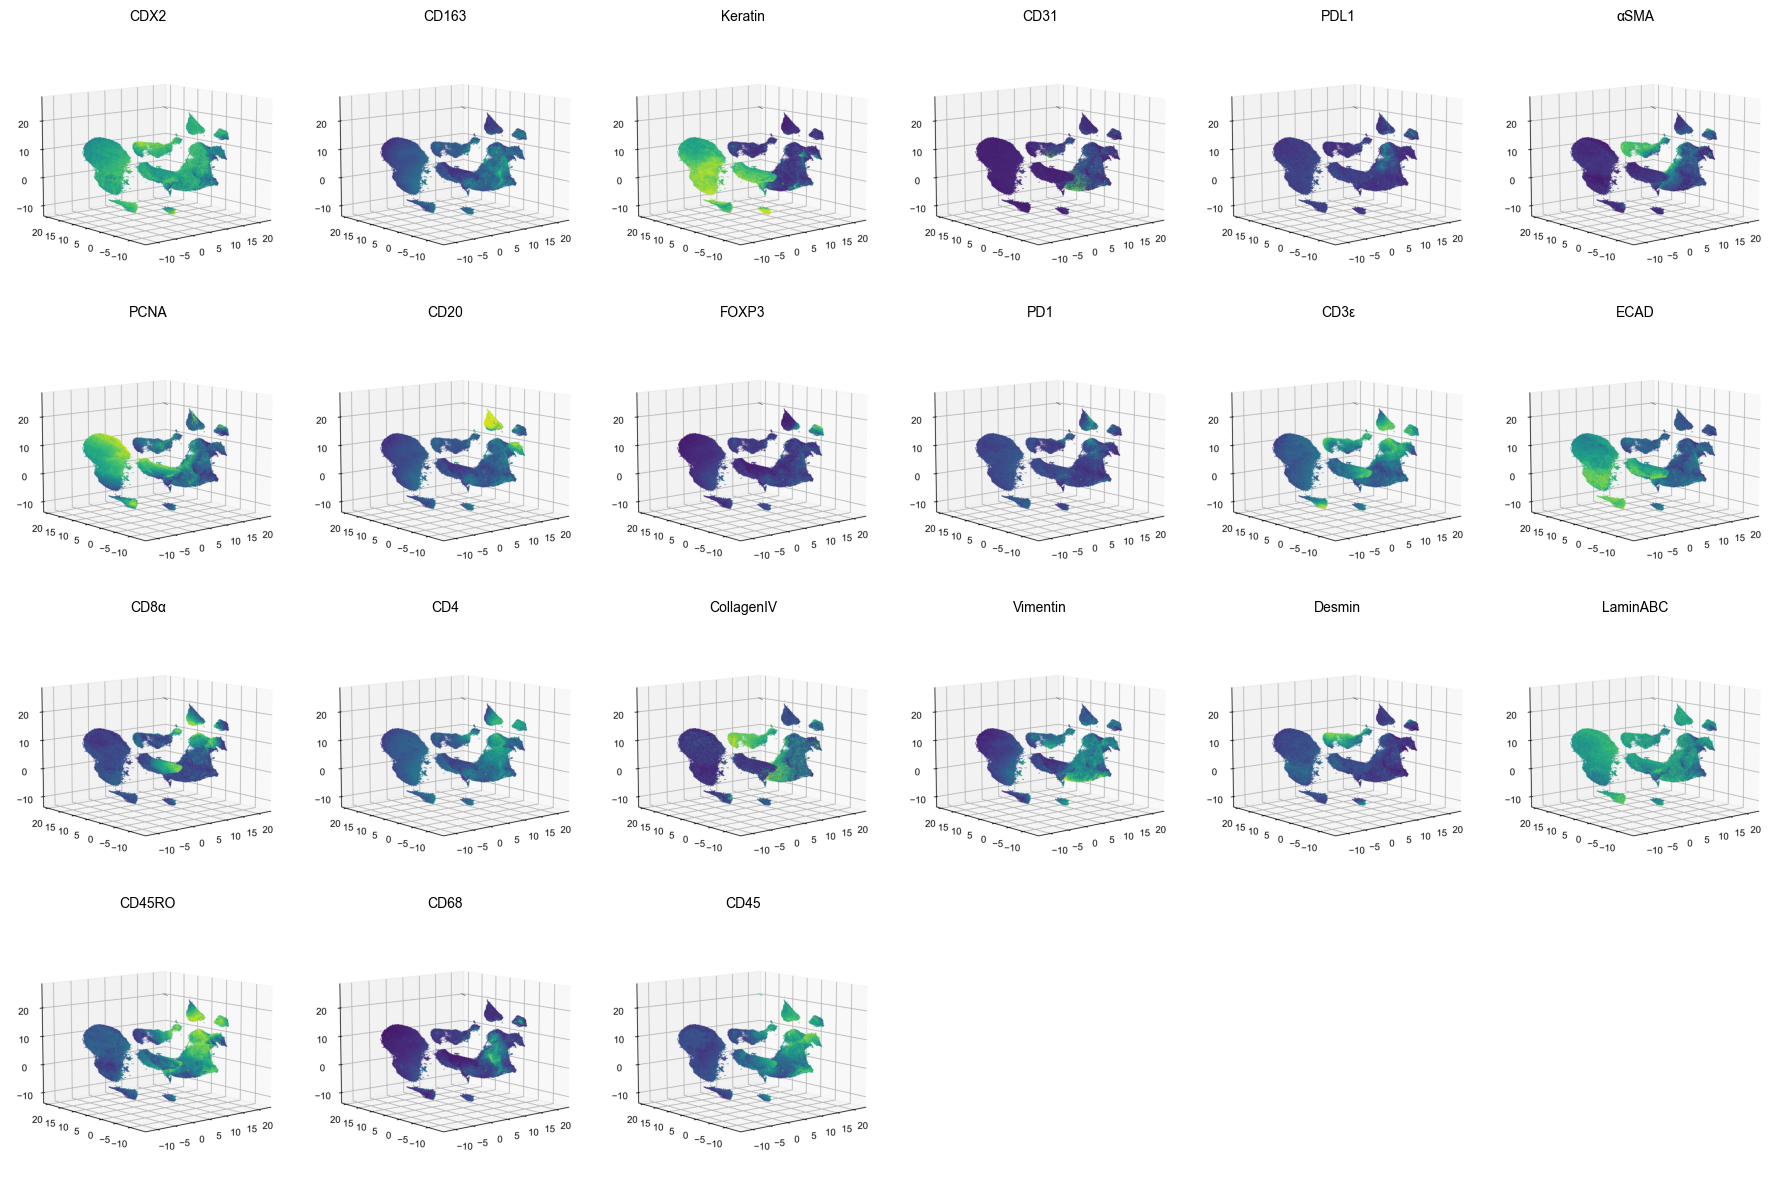

In [5]:
# Generate single facetgrid showing all channels
df_melt = (
    df[abx_channels + ['emb1', 'emb2', 'emb3']]
    .sample(frac=0.1)
    .reset_index(drop=True)
    .melt(id_vars=['emb1', 'emb2', 'emb3'], var_name='abx')
)
df_melt['abx'] = [i.split('_nucleiRingMask')[0] for i in df_melt['abx']]

ch_dict = {
    'anti_CD3': 'CD3\u03B5', 'anti_CD45RO': 'CD45RO', 'Keratin_570': 'Keratin', 'aSMA_660': '\u03B1SMA',
    'CD4_488': 'CD4', 'CD45_PE': 'CD45', 'PD1_647': 'PD1', 'CD20_488': 'CD20', 'CD68_555': 'CD68',
    'CD8a_660': 'CD8\u03B1', 'CD163_488': 'CD163', 'FOXP3_570': 'FOXP3', 'PDL1_647': 'PDL1',
    'Ecad_488': 'ECAD', 'Vimentin_555': 'Vimentin', 'CDX2_647': 'CDX2', 'LaminABC_488': 'LaminABC',
    'Desmin_555': 'Desmin', 'CD31_647': 'CD31', 'PCNA_488': 'PCNA', 'CollagenIV_647': 'CollagenIV'
}

long_table = pd.DataFrame(columns=['channel', 'image'])
for e, file in enumerate(os.listdir(out)):
    if not file.startswith(('.', 'combined.png')):
        channel_name = ch_dict[file.split('.png')[0]]
        img = Image.open(os.path.join(out, file))
        arr = asarray(img)
        long_table.loc[e, 'channel'] = channel_name
        long_table.loc[e, 'image'] = arr

g = sns.FacetGrid(long_table, col='channel', col_wrap=6, sharex=False, sharey=False)

g.map(
    lambda image, **kwargs: (plt.imshow(image.values[0]), plt.grid(False)), 'image'
)

for ax in g.axes.flatten():
    ax.axis('off')

g.set_titles(col_template="{col_name}", fontweight='normal', size=10)
g.fig.tight_layout()

plt.savefig(
    os.path.join(out, 'combined.png'), bbox_inches='tight', dpi=800
)
plt.show()
plt.close('all')